In [1]:
using IndexedGraphs, SparseArrays, MatrixProductBP, Random, Plots, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

# OBC

## MonteCarlo

In [2]:
# include("ising2d_montecarlo/IsingMC.jl");
include("ising2d_montecarlo/wolff.jl");

In [25]:
N = 30
T = N - 1
T1 = T + 1
d = (N, T1)
β = 0.5
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1)
J = J0 * lattice(d, (true, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+i+1) for i in 1:N-1]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [26]:
ntherm = 10^4
nsamples = 10^6

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm)
m_mc = magnetizations(stats);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


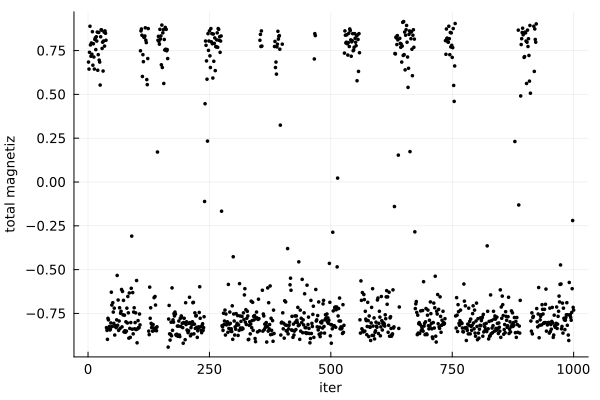

In [27]:
scatter(magnetization(stats)[1:1000:end], xlabel="iter", ylabel="total magnetiz", label="",
    ms=2, c=:black, msc=:auto)

mean(m_mc) = -0.3848280777777777


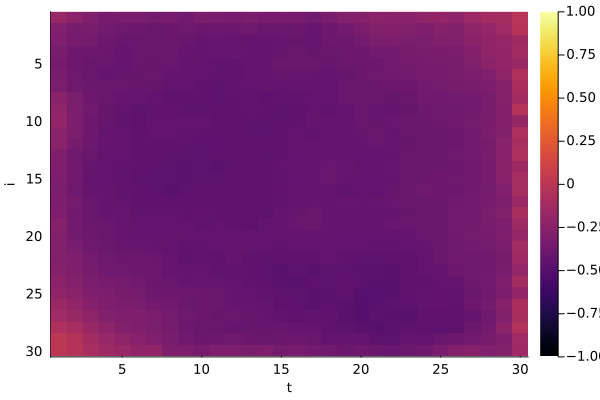

In [28]:
@show mean(m_mc)
heatmap(reshape(m_mc, N, T1), clims=(-1,1), xlabel="t", ylabel="i", yflip=true)

## MPBP

In [29]:
struct Ising2DOpen{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DOpen)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + (f.border ? 0 : f.βJh*spin(xₙᵢᵗ[1])) )
    exp(h)
end

In [30]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, true))
h_matrix = reshape(h, N, T1)

w = [[Ising2DOpen(βJ, βJ, i==1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [31]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [32]:
svd_trunc = TruncBondThresh(8, 1e-8)
iters, cb = iterate!(bp, maxiter=80; svd_trunc, cb, tol=1e-5, damp=0.2);

Running MPBP: iter 31 	 Time: 0:02:14
  Δ:                  0.0
  SVD tolerance, m':  1.0e-8, 8

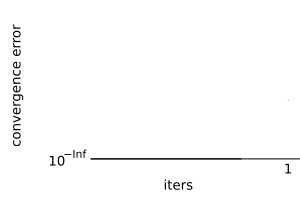

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 31 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 31 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: I

In [33]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

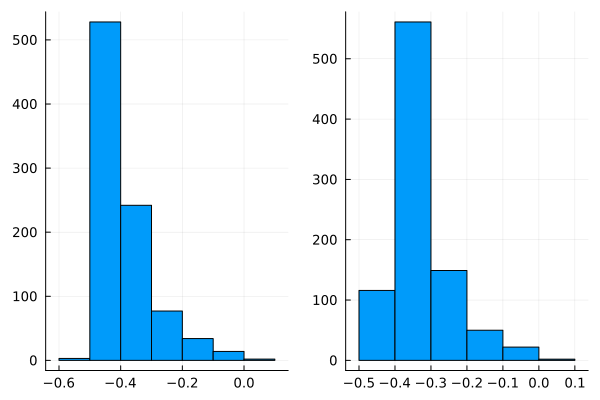

In [34]:
plot(histogram(m_mc, nbins=8), histogram(reduce(vcat, means(spin, bp)), nbins=8))
# heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

r = 0.9973773811972078


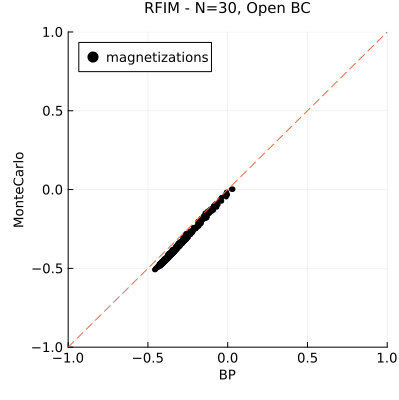

In [35]:
scatter(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc)
@show r
plot!(title="RFIM - N=$N, Open BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

# OBC in 1 direction

## MonteCarlo

In [96]:
N = 30
T = N-1
T1 = T + 1
d = (N, T1)
β = 0.5
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
# h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1) .- 0.5

hh = h0*randn(T1)
h = reduce(hcat, fill(hh, N))'[:]

J = J0 * lattice(d, (false, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+mod(i,N)+1) for i in 1:N]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [97]:
ntherm = 10^4
nsamples = 10^5

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm)
m_mc = magnetizations(stats);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


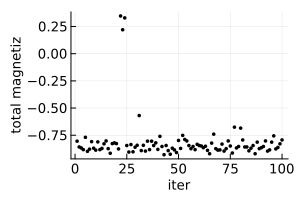

In [98]:
scatter(magnetization(stats)[1:1000:end], xlabel="iter", ylabel="total magnetiz", label="",
    ms=2, c=:black, msc=:auto, size=(300,200))

## MPBP

In [99]:
struct Ising2DPeriodic{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DPeriodic)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + f.βJh*spin(xₙᵢᵗ[f.border ? 2 : 1]) )
    exp(h)
end

In [100]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, false))
h_matrix = reshape(h, N, T1)

w = [[Ising2DPeriodic(βJ, βJ, i == N || i == 1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [101]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [102]:
svd_trunc = TruncBondThresh(8, 1e-8)
maxiter = 100
iters, cb = iterate!(bp; maxiter, svd_trunc, cb, tol=1e-4, damp=0.2)
iters == maxiter && @warn "BP did not converge";

Running MPBP: iter 47 	 Time: 0:03:41
  Δ:                  8.840292937506433e-5
  SVD tolerance, m':  1.0e-8, 8

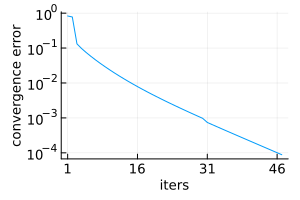

In [103]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

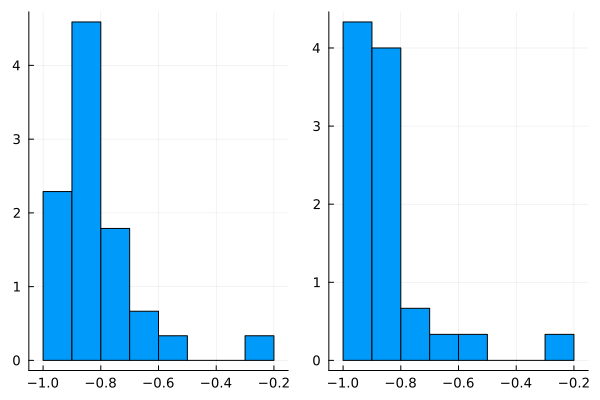

In [104]:
plot( histogram(m_mc, nbins=8, normalize=true), 
      histogram(reduce(vcat, means(spin, bp)), nbins=8, normalize=true) )
# heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

r = 0.9896664931289723


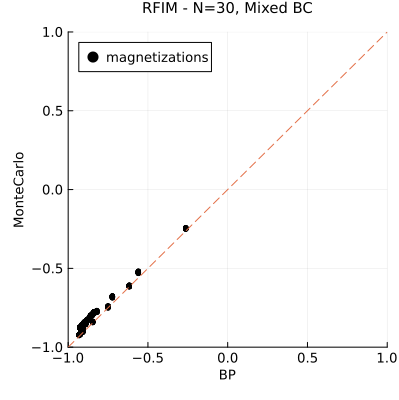

In [105]:
scatter(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc)
@show r
plot!(title="RFIM - N=$N, Mixed BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

## MPBP infinite

In [106]:
struct Ising2DInfinite{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
end

spin(x, i = 0) = 3-2x

function (f::Ising2DInfinite)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + f.βJh*sum(spin, xₙᵢᵗ) )
    exp(h)
end

In [113]:
# βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, false))
h_matrix = reshape(h, N, T1)

wᵢ = [Ising2DInfinite(β*J0, β*J0) for _ in 1:T+1]
ϕᵢ = [[exp(β*ht), exp(-β*ht)] for ht in hh]
# ϕᵢ = map(1:T1) do t
#     h = h0 * randn()
#     [exp(β*h), exp(-β*h)]
# end

bp_inf = mpbp_infinite_graph(2, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp_inf; f=spin, showprogress=false);

# w = [[Ising2DPeriodic(βJ, βJ, i == N || i == 1) for t=0:T] for i=1:N]
# ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
# bp = mpbp(G, w, fill(2,N), T; ϕ);

In [114]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp_inf; f=spin);

In [115]:
svd_trunc = TruncBondThresh(10, 1e-10)
maxiter = 100
iters, cb = iterate!(bp_inf; maxiter, svd_trunc, cb, tol=1e-5, damp=0.2)
iters == maxiter && @warn "BP did not converge";

Running MPBP: iter 30 	 Time: 0:00:10
  Δ:                  8.47861506070302e-6
  SVD tolerance, m':  1.0e-10, 10

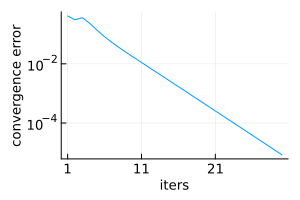

In [116]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

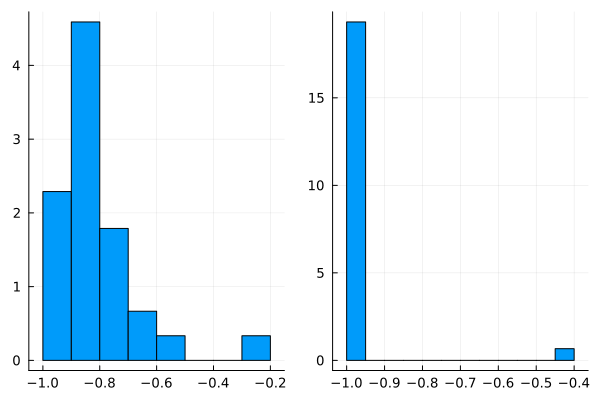

In [117]:
plot( histogram(m_mc, nbins=10, normalize=true), 
      histogram(reduce(vcat, means(spin, bp_inf)), nbins=10, normalize=true) )
# heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

In [118]:
mean(m_mc), mean(only(means(spin, bp_inf)))

(-0.8070838888888888, -0.9722755220693121)

## Infinite graph

In [46]:
N = 100
I = (N, N)
meas = mcising(I, β; h = h0 * randn(prod(I)), J = [J*ones(2^length(I)) for _ in 1:prod(I)], 
    nterm=20, nmeas=5*10^2, nsweep=2*10^2)
mean(abs, meas.mag)

0.9093336

In [36]:
T = N
wᵢ = [Ising2D(β*J, β*J, β*h0*randn()) for _ in 1:T+1]

bp_inf = mpbp_infinite_graph(2, wᵢ, 2)
cb = CB_BP(bp_inf; f=spin, showprogress=false)

In [37]:
svd_trunc = TruncBondThresh(8, 1e-6)
iters, cb = iterate!(bp_inf, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.2);

In [45]:
m_bp = means(spin, bp_inf)
mean(abs, m[t] for m in m_bp, t in (T÷4:T÷4*3))

0.9118196875948974

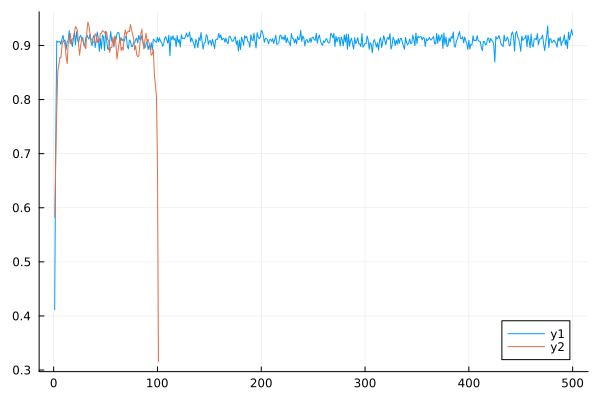

In [44]:
plot(meas.mag)
plot!(only(m_bp))

In [74]:
Ns = 100:20:140
ms_mc = zeros(length(Ns))
ms_bp = zeros(length(Ns))
meass = []
bps = []
cbs = []

β = 0.5
J = 1.0
h0 = 0.1

for j in eachindex(Ns)
    N = Ns[j]
    println("Size $j of $(length(Ns)) - N=$N")
    println("-- MonteCarlo")
    I = (N, N)
    meas = mcising(I, β; h = h0 * randn(prod(I)), J = [J*ones(2^length(I)) for _ in 1:prod(I)], 
        nterm=300, nmeas=5*10^2, nsweep=2*10^2)
    ms_mc[j] = mean(abs, meas.mag)
    
    println("-- BP")
    T = N
    wᵢ = [Ising2D(β*J, β*J, β*h0*randn()) for _ in 1:T+1]
    bp_inf = mpbp_infinite_graph(2, wᵢ, 2)
    cb = CB_BP(bp_inf; f=spin, showprogress=false)
    svd_trunc = TruncBondThresh(8, 1e-7)
    iters, cb = iterate!(bp_inf, maxiter=100; svd_trunc, cb, tol=1e-3, damp=0.2)
    m_bp = means(spin, bp_inf)
    ms_bp[j] = mean(abs, m[t] for m in m_bp, t in (T÷4:T÷4*3))
    
    push!(meass, meas); push!(bps, bp_inf); push!(cbs, cb)
end

Size 1 of 3 - N=100
-- MonteCarlo
-- BP
Size 2 of 3 - N=120
-- MonteCarlo
-- BP
Size 3 of 3 - N=140
-- MonteCarlo
-- BP


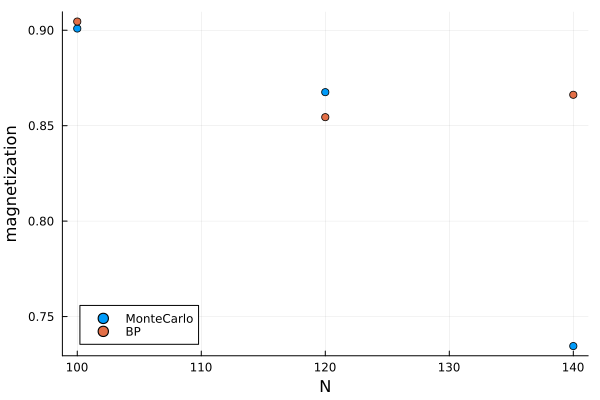

In [75]:
scatter(Ns, ms_mc, label="MonteCarlo", xlabel="N", ylabel="magnetization")
scatter!(Ns, ms_bp, label="BP")

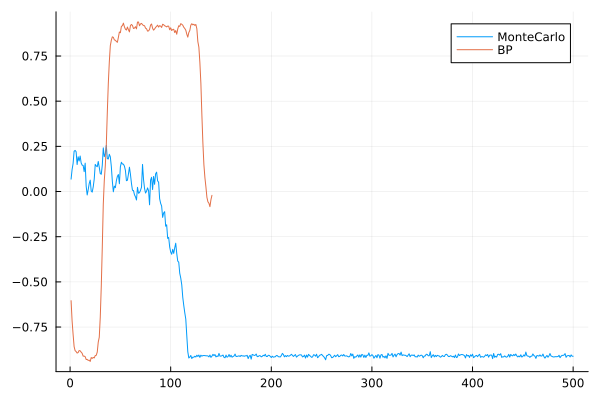

In [77]:
i = 3
plot(meass[i].mag, label="MonteCarlo")
plot!(only(means(spin, bps[i])), label="BP")